In [1]:
from generator import Generator
from critic import Critic
from dog_dataset import DogData

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import optim

In [3]:
batchSize = 1

In [4]:
transform = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) ] )
dogdata = DogData(transform)
dogloader = DataLoader(dogdata, shuffle=True, batch_size=batchSize, num_workers=3)

In [5]:
import matplotlib.pyplot as plt

In [6]:
gen_img = torch.randn([1, 3, 100, 100], requires_grad=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


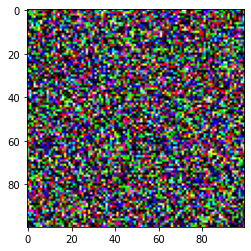

In [7]:
plt.imshow(gen_img[0].permute(1,2,0).detach())
plt.show()

In [8]:
def get_critic_scores(real_batch, batchSize, critic):
    #generator.batchSize = batchSize
    critic.batchSize = batchSize
    #generate fake images
    #randoBatch = torch.rand([batchSize, 100, 1, 1])
    #generated = generator(randoBatch)
    generated = gen_img
    #compute scores of both real and fake using the critic
    real_scores = critic(real_batch[0])
    gen_scores = critic(generated)
    return ( torch.sum(real_scores) , torch.sum(gen_scores) )

In [9]:
def get_generator_score(batchSize, critic):
    #generator.batchSize = batchSize
    #generate fake images
    #randoBatch = torch.rand([batchSize, 100, 1, 1])
    #generated = generator(randoBatch)
    generated = gen_img
    #compute scores of generated using critic
    gen_scores = critic(generated)
    return gen_scores#torch.sum(gen_scores)

In [10]:
class WeightClipper(object):

    def __init__(self, frequency=5):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w.clamp(-0.01,0.01)
            module.weight.data = w

In [11]:
critic = Critic()
generator = Generator()
clipper = WeightClipper()
critic.apply(clipper)

Critic(
  (convBlocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fcBlocks): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10368, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Linear(in_

In [16]:
num_epochs = 100
critic_epochs = 2
gen_epochs = 1

In [17]:
criticOptim = optim.RMSprop(critic.parameters(), lr=0.0005)#, momentum=0)
genOptim = optim.RMSprop([gen_img], lr=0.08, momentum=0)

In [ ]:
for epoch in range(num_epochs):
    print('Entering epoch yay: ' + str(epoch))
    realScore = 0.0 
    fakeScore = 0.0
    mainLoss = 0.0
    #critic training loop
    for batch_no, batch in enumerate(dogloader):
        print('Critic batch: ' + str(batch_no))
        scores = get_critic_scores(batch, batchSize, critic)
        real_score = scores[0]
        gen_score = scores[1]
        #loss function
        loss = -( real_score - gen_score ) #+ 0.01 * ( torch.pow(real_score,2) + torch.pow(gen_score,2) ) #penalize for distance away from 0
        #some tracking of numbers here
        realScore += real_score.item()
        fakeScore += gen_score.item()
        mainLoss += loss.item()
        #optimize
        criticOptim.zero_grad()
        loss.backward()
        criticOptim.step()
        
        if (batch_no % critic_epochs == critic_epochs-1):
            break
    print(realScore)
    print(fakeScore)
    print(mainLoss)
    
    mainLoss = 0.0
    #generator training loop
    for gepoch in range(gen_epochs):
        print('Generator batch: ' + str(gepoch))
        gen_score = get_generator_score(batchSize, critic)
        #loss function
        loss = -gen_score
        #tracking of numbers
        mainLoss += loss.item()
        #optimize
        genOptim.zero_grad()
        loss.backward()
        genOptim.step()
    print(mainLoss)

Entering epoch yay: 0
Critic batch: 0
Critic batch: 1
-10339325.0
-72197434.0
-61858110.0
Generator batch: 0
62541800.0
Entering epoch yay: 1
Critic batch: 0
Critic batch: 1
-26435499.0
-301613400.0
-275177896.0
Generator batch: 0
208933040.0
Entering epoch yay: 2
Critic batch: 0
Critic batch: 1
-21223548.0
-116003488.0
-94779940.0
Generator batch: 0
67767936.0
Entering epoch yay: 3
Critic batch: 0
Critic batch: 1
-39600308.0
-369897760.0
-330297456.0
Generator batch: 0
222216928.0
Entering epoch yay: 4
Critic batch: 0
Critic batch: 1
-17484562.75
-227877936.0
-210393376.0
Generator batch: 0
131313288.0
Entering epoch yay: 5
Critic batch: 0
Critic batch: 1
-42147738.0
-481697792.0
-439550064.0
Generator batch: 0
293656576.0
Entering epoch yay: 6
Critic batch: 0
Critic batch: 1
-49207468.0
-355703760.0
-306496288.0
Generator batch: 0
181847152.0
Entering epoch yay: 7
Critic batch: 0
Critic batch: 1
-34041380.0
-610270752.0
-576229376.0
Generator batch: 0
371085632.0
Entering epoch yay: 

Critic batch: 0
Critic batch: 1
-5276376576.0
-48560277504.0
-43283900416.0
Generator batch: 0
25381171200.0
Entering epoch yay: 65


In [ ]:
plt.imshow(dogdata[0][0].permute(1,2,0))
plt.show()

critic.batchSize = 1
critic.eval()
print(critic(dogdata[800][0].unsqueeze(0)))
rando = torch.rand([1, 100, 1, 1])
print(critic(gen_img))

gen = generator(rando)
plt.imshow(gen_img[0].permute(1,2,0).detach().numpy())
plt.show()